


# Part 2 : Model-Training & CNN Test

## Importing Libraries

In [ ]:
import tensorflow as tf
tf.config.optimizer.set_jit(True)
import matplotlib.pyplot as plt

import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:


X = np.load("X_train (1).npy")
y = np.load("y_train (1).npy")
X_test = np.load("X_test (1).npy")
y_test = np.load("y_test (1).npy")

X_train, X_val, y_train_raw, y_val_raw = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

num_classes = 16

# Convert to categorical
y_train = to_categorical(y_train_raw, num_classes)
y_val = to_categorical(y_val_raw, num_classes)
y_test = to_categorical(y_test, num_classes)


print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (30420, 45, 45, 1)
Validation data shape: (3381, 45, 45, 1)
Test data shape: (8458, 45, 45, 1)


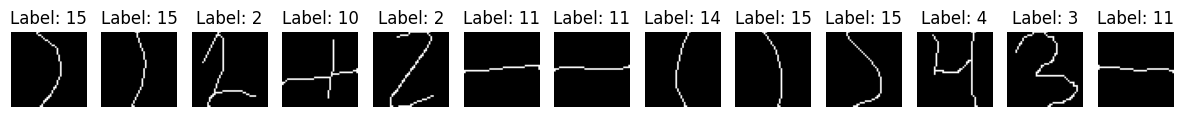

In [ ]:
n = 13
plt.figure(figsize=(15,3))

for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train_raw[i]}")
    plt.axis('off')

plt.show()


In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_raw),
    y=y_train_raw
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.518570287539936), 1: np.float64(0.41794899978017147), 2: np.float64(0.42657617231321515), 3: np.float64(1.0699212155317952), 4: np.float64(1.6098645215918712), 5: np.float64(2.62603591160221), 6: np.float64(3.2555650684931505), 7: np.float64(3.527365491651206), 8: np.float64(3.6145437262357416), 9: np.float64(3.5603932584269664), 10: np.float64(0.49319066147859925), 11: np.float64(0.4533261802575107), 12: np.float64(4.411252900232019), 13: np.float64(16.975446428571427), 14: np.float64(0.6659369527145359), 15: np.float64(0.6671052631578948)}


In [ ]:
X_train.shape

(30420, 45, 45, 1)

## Building the CNN model

In [ ]:
model = keras.Sequential([
            # Block 1
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(45, 45, 1)),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.2),

            # Block 2
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Block 3
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Block 4
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            # Global pooling + Dense
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(16, activation='softmax')
        ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer = Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]  # top_3 để theo dõi performance
)

In [ ]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 45, 45, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             

 Total params: 847,760 (3.23 MB)

 Trainable params: 845,808 (3.23 MB)

 Non-trainable params: 1,952 (7.62 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Giảm learning rate khi plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

# Save best model
checkpoint = ModelCheckpoint(
    'best_math_ocr_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [reduce_lr, early_stop, checkpoint]


## Training the model

In [ ]:
# Training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Training với class weights
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Epoch 1/50
951/951 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5404 - loss: 1.8423 - top_3_accuracy: 0.7836
Epoch 1: val_accuracy improved from -inf to 0.82017, saving model to best_math_ocr_model.h5


951/951 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.5405 - loss: 1.8417 - top_3_accuracy: 0.7837 - val_accuracy: 0.8202 - val_loss: 0.6377 - val_top_3_accuracy: 0.9642 - learning_rate: 0.0010
Epoch 2/50
948/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8247 - loss: 0.5232 - top_3_accuracy: 0.9774
Epoch 2: val_accuracy improved from 0.82017 to 0.91156, saving model to best_math_ocr_model.h5


951/951 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8247 - loss: 0.5231 - top_3_accuracy: 0.9774 - val_accuracy: 0.9116 - val_loss: 0.3629 - val_top_3_accuracy: 0.9882 - learning_rate: 0.0010
Epoch 3/50
949/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8535 - loss: 0.3814 - top_3_accuracy: 0.9856
Epoch 3: val_accuracy improved from 0.91156 to 0.94676, saving model to best_math_ocr_model.h5


951/951 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8535 - loss: 0.3814 - top_3_accuracy: 0.9856 - val_accuracy: 0.9468 - val_loss: 0.2248 - val_top_3_accuracy: 0.9938 - learning_rate: 0.0010
Epoch 4/50
947/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8673 - loss: 0.3430 - top_3_accuracy: 0.9876
Epoch 4: val_accuracy improved from 0.94676 to 0.95001, saving model to best_math_ocr_model.h5


951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8674 - loss: 0.3430 - top_3_accuracy: 0.9877 - val_accuracy: 0.9500 - val_loss: 0.2323 - val_top_3_accuracy: 0.9947 - learning_rate: 0.0010
Epoch 5/50
946/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8830 - loss: 0.3134 - top_3_accuracy: 0.9913
Epoch 5: val_accuracy did not improve from 0.95001
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8829 - loss: 0.3134 - top_3_accuracy: 0.9913 - val_accuracy: 0.9142 - val_loss: 0.3199 - val_top_3_accuracy: 0.9917 - learning_rate: 0.0010
Epoch 6/50
949/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8851 - loss: 0.2619 - top_3_accuracy: 0.9934
Epoch 6: val_accuracy did not improve from 0.95001
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8851 - loss: 0.2620 - top_3_accuracy: 0.9934 - val_accuracy: 0.8725 - val_loss: 0.3473 - val_top_3_accuracy: 0.9885 - learning_rate: 0.0010
Epoch 7/50
949/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8860 - loss: 0.2862 - t

951/951 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8848 - loss: 0.3111 - top_3_accuracy: 0.9902 - val_accuracy: 0.9722 - val_loss: 0.1445 - val_top_3_accuracy: 0.9965 - learning_rate: 0.0010
Epoch 9/50
946/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9019 - loss: 0.2502 - top_3_accuracy: 0.9933
Epoch 9: val_accuracy did not improve from 0.97220
951/951 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9019 - loss: 0.2502 - top_3_accuracy: 0.9933 - val_accuracy: 0.9379 - val_loss: 0.1539 - val_top_3_accuracy: 0.9973 - learning_rate: 0.0010
Epoch 10/50
948/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8966 - loss: 0.2743 - top_3_accuracy: 0.9917
Epoch 10: val_accuracy did not improve from 0.97220
951/951 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8966 - loss: 0.2743 - top_3_accuracy: 0.9917 - val_accuracy: 0.9003 - val_loss: 0.2372 - val_top_3_accuracy: 0.9956 - learning_rate: 0.0010
Epoch 11/50
946/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8955 - loss: 0.2520

951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9452 - loss: 0.1212 - top_3_accuracy: 0.9980 - val_accuracy: 0.9731 - val_loss: 0.1189 - val_top_3_accuracy: 0.9979 - learning_rate: 2.5000e-04
Epoch 24/50
946/951 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9579 - loss: 0.1105 - top_3_accuracy: 0.9981
Epoch 24: val_accuracy did not improve from 0.97308
951/951 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9579 - loss: 0.1105 - top_3_accuracy: 0.9981 - val_accuracy: 0.9725 - val_loss: 0.1108 - val_top_3_accuracy: 0.9982 - learning_rate: 2.5000e-04
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 12.


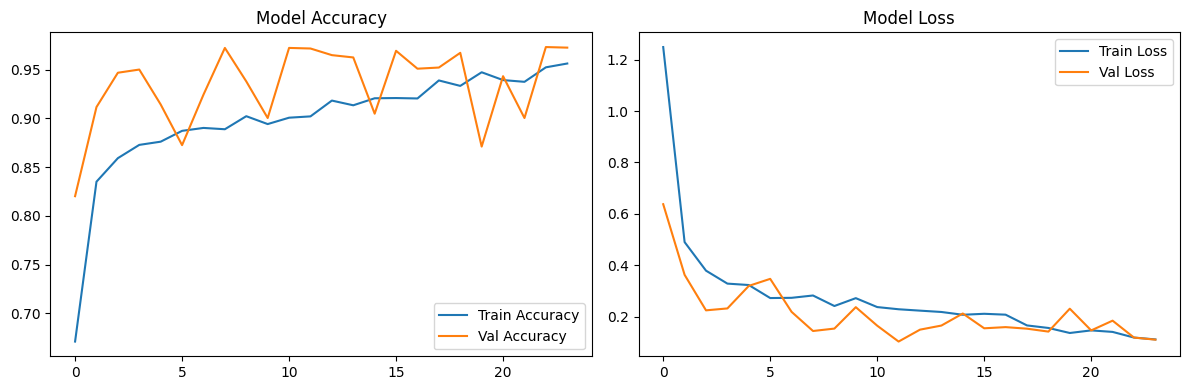

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)
# # serialize weights to HDF5
model.save_weights("model_final.weights.h5")


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('best_math_ocr_model.h5')


In [ ]:
loss, acc, top3_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9623 - loss: 0.1209 - top_3_accuracy: 0.9971
Test Loss: 0.1128
Test Accuracy: 0.9729
Top-3 Accuracy: 0.9982


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


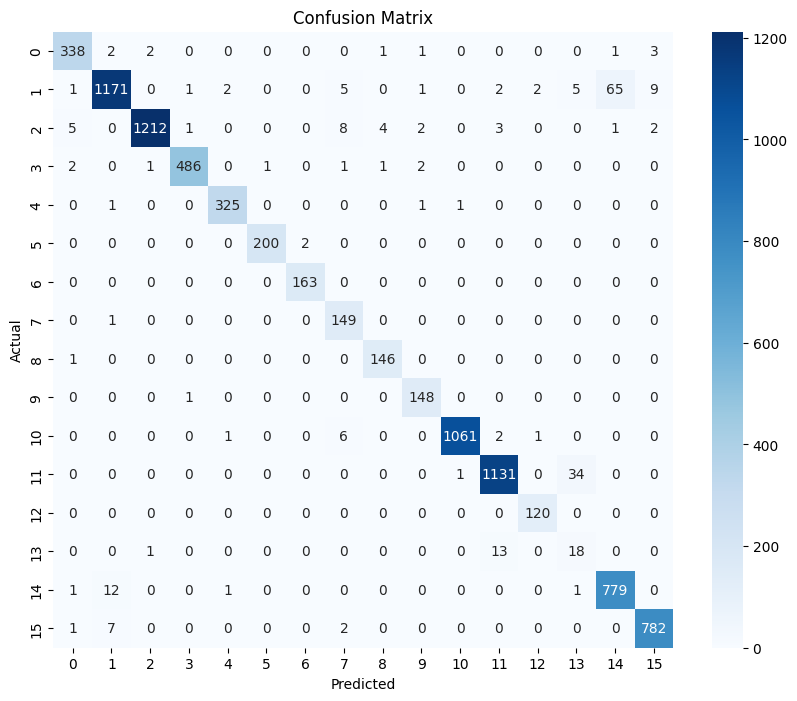

              precision    recall  f1-score   support

           0     0.9685    0.9713    0.9699       348
           1     0.9807    0.9264    0.9528      1264
           2     0.9967    0.9790    0.9878      1238
           3     0.9939    0.9838    0.9888       494
           4     0.9878    0.9909    0.9893       328
           5     0.9950    0.9901    0.9926       202
           6     0.9879    1.0000    0.9939       163
           7     0.8713    0.9933    0.9283       150
           8     0.9605    0.9932    0.9766       147
           9     0.9548    0.9933    0.9737       149
          10     0.9981    0.9907    0.9944      1071
          11     0.9826    0.9700    0.9763      1166
          12     0.9756    1.0000    0.9877       120
          13     0.3103    0.5625    0.4000        32
          14     0.9208    0.9811    0.9500       794
          15     0.9824    0.9874    0.9849       792

    accuracy                         0.9729      8458
   macro avg     0.9292   

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán nhãn
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, digits=4))


<Axes: >

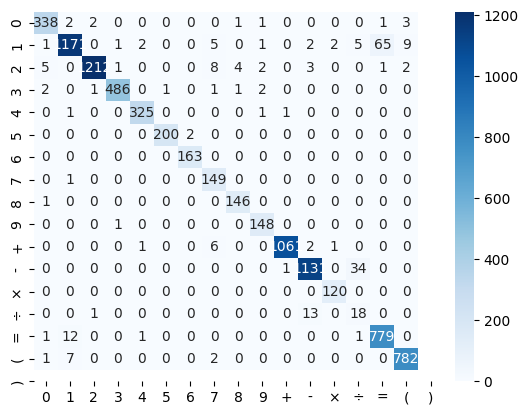

In [ ]:
labels = ['0','1','2','3','4','5','6','7','8','9','+','-','×','÷','=','(',')']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
